In [1]:
# alibi
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from alibi_detect.cd import KSDrift
from alibi_detect.models.tensorflow import scale_by_instance
from alibi_detect.utils.fetching import fetch_tf_model, fetch_detector
from alibi_detect.saving import save_detector, load_detector

# wilds
from typing import Tuple, Generator, Callable, Optional
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from wilds.common.data_loaders import get_train_loader, get_eval_loader
from wilds import get_dataset
import alibi_detect
import torchvision
import wilds
from alibi_detect.models.pytorch import trainer

print(f"Alibi Detect Version: {alibi_detect.__version__}")
print(f"Torch Version: {torch.__version__}")
print(f"Torchvision Version: {torchvision.__version__}")
print(f"Wilds Version: {wilds.__version__}")


torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cpu')
%matplotlib inline


2022-12-30 14:37:47.863254: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-30 14:37:47.863284: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/jinglewsl/miniconda3/envs/alibitorchwhy/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Alibi Detect Version: 0.10.4
Torch Version: 1.13.0+cu117
Torchvision Version: 0.14.0+cu117
Wilds Version: 2.0.0


In [2]:
# datensatz camelyon laden
%cd  '/home/jinglewsl/evoila/projects/image-drift-monitoring'
%pwd
camelyon = get_dataset(dataset="camelyon17",download=False)

WILDS_PATH = 'data'
N = 10000 # Size of reference set
DOWNLOAD = False
img_size = (96,96)
ds_train = camelyon.get_subset('train',transform=transforms.Compose([transforms.Resize(img_size), transforms.ToTensor()]))
train_loader = iter(get_train_loader('standard',ds_train,1))

ds_test = camelyon.get_subset('test',transform=transforms.Compose([transforms.Resize(img_size), transforms.ToTensor()]))
test_loader = iter(get_train_loader('standard',ds_test,1))

x_ref = np.stack([next(train_loader)[0][0].numpy() for _ in range(N)],axis=0)
x_test = np.stack([next(test_loader)[0][0].numpy() for _ in range(N)],axis=0)


/home/jinglewsl/evoila/projects/image-drift-monitoring


In [3]:
# We split the original test set in a reference dataset and a dataset which should not be rejected under the H0 of the K-S test.
# We also split the corrupted data by corruption type:
np.random.seed(0)
n_test = x_ref.shape[0]
idx = np.random.choice(n_test, size=n_test // 2, replace=False)
idx_h0 = np.delete(np.arange(n_test), idx, axis=0)
X_ref = x_ref[idx]
X_h0= x_ref[idx_h0]
print(X_ref.shape, X_h0.shape)
print(x_ref.shape, x_test.shape)

(5000, 3, 96, 96) (5000, 3, 96, 96)
(10000, 3, 96, 96) (10000, 3, 96, 96)


In [4]:
# Random encoder (Untrained Auto Encoder)
from functools import partial
from tensorflow.keras.layers import Conv2D, Dense, Flatten, InputLayer, Reshape
from alibi_detect.cd.tensorflow import preprocess_drift

tf.random.set_seed(0)

# define encoder
encoding_dim = 96
encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(3,96,96)),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu), s
      Conv2D(256, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(encoding_dim,)
  ]
)

# define preprocessing function
preprocess_fn = partial(preprocess_drift, model=encoder_net, batch_size=512)

# initialise drift detector
p_val = .05
cd = KSDrift(X_ref, p_val=p_val, preprocess_fn=preprocess_fn)

# we can also save/load an initialised detector
filepath = '/home/jinglewsl/evoila/projects/image-drift-monitoring/src/modules/alibi_detect/ks_detector_camelyon'  # change to directory where detector is saved
save_detector(cd, filepath)

2022-12-30 14:38:22.618552: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-30 14:38:22.618581: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-30 14:38:22.618597: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jingle): /proc/driver/nvidia/version does not exist
2022-12-30 14:38:22.619141: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
assert cd.p_val / cd.n_features == p_val / encoding_dim

In [7]:
#Let’s check whether the detector thinks drift occurred on the different test sets and time the prediction calls:

from timeit import default_timer as timer

labels = ['No!', 'Yes!']

def make_predictions(cd, x_h0,x_corr=None):
    t = timer()
    preds = cd.predict(x_h0)
    dt = timer() - t
    print('No corruption')
    print('Drift? {}'.format(labels[preds['data']['is_drift']]))
    print('Feature-wise p-values:')
    print(preds['data']['p_val'])
    print('len:{}'.format(len(preds['data']['p_val'])))
    print(f'Time (s) {dt:.3f}')


    if len(x_corr) > 0:
        t = timer()
        preds_2 = cd.predict(x_corr)
        dt = timer() - t
        print('')
        print('Drift? {}'.format(labels[preds_2['data']['is_drift']]))
        print('Feature-wise p-values:')
        print(preds_2['data']['p_val'])
        print('len:{}'.format(len(preds_2['data']['p_val'])))
        print(f'Time (s) {dt:.3f}')
        return preds_2  
    

In [8]:
# We split the original test set in a reference dataset and a dataset which should not be rejected under the H0 of the K-S test.
# We also split the corrupted data by corruption type:
np.random.seed(0)
n_test = x_test.shape[0]
idx = np.random.choice(n_test, size=2, replace=False)
idx_h0 = np.delete(np.arange(n_test), idx, axis=0)



x_test_subset = x_test[idx] 

print(len(x_test))
print(len(x_test_subset))

10000
2


In [10]:
make_predictions(cd, X_ref,x_test)

No corruption
Drift? No!
Feature-wise p-values:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
len:96
Time (s) 1.694

Drift? Yes!
Feature-wise p-values:
[8.2731348e-34 1.3538261e-05 4.3875215e-32 0.0000000e+00 5.3779614e-22
 1.0022088e-37 0.0000000e+00 1.9791989e-25 2.0081222e-12 6.5861028e-44
 6.0687063e-12 0.0000000e+00 0.0000000e+00 3.2499511e-25 0.0000000e+00
 3.7488241e-21 6.5872262e-21 1.1210388e-44 5.2898953e-04 2.6235806e-03
 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.3794048e-42 0.0000000e+00
 3.7177235e-02 2.4559589e-13 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 9.8090893e-45
 0.0000000e+00 7.4119142e-09 1.2627554e-34 0.0000000e+00 0.0000000e+00
 3.7989507e-16 0.0000000e+00 0.00

{'data': {'is_drift': 1,
  'distance': array([0.1072, 0.0422, 0.1044, 0.2172, 0.0862, 0.1133, 0.1611, 0.0928,
         0.0643, 0.1223, 0.063 , 0.1791, 0.2027, 0.0924, 0.1624, 0.0845,
         0.084 , 0.1234, 0.0351, 0.0315, 0.3363, 0.2969, 0.2423, 0.1201,
         0.2032, 0.0244, 0.0667, 0.1639, 0.1635, 0.3009, 0.2287, 0.1279,
         0.2754, 0.1769, 0.1235, 0.1375, 0.0539, 0.1085, 0.2175, 0.2383,
         0.0736, 0.1447, 0.2008, 0.1656, 0.3083, 0.1865, 0.2   , 0.053 ,
         0.1691, 0.0419, 0.3793, 0.1052, 0.0617, 0.1527, 0.135 , 0.156 ,
         0.2561, 0.0385, 0.0583, 0.086 , 0.2572, 0.1781, 0.2074, 0.2301,
         0.1875, 0.2861, 0.2052, 0.0901, 0.1189, 0.0491, 0.0543, 0.1078,
         0.161 , 0.0682, 0.0805, 0.1519, 0.0859, 0.1831, 0.1722, 0.2372,
         0.0605, 0.0496, 0.2454, 0.0175, 0.159 , 0.1306, 0.1298, 0.2361,
         0.0714, 0.2146, 0.1332, 0.0702, 0.0402, 0.0968, 0.3278, 0.1372],
        dtype=float32),
  'p_val': array([8.2731348e-34, 1.3538261e-05, 4.3875215e-32,

In [28]:
preds_2 =make_predictions(cd,x_ref,x_test_subset)

No corruption
Drift? No!
Feature-wise p-values:
[0.99990505 0.9569839  0.9929129  0.99571806 0.9723178  0.99571806
 0.9889224  0.9999701  0.9975805  0.99444854 0.9929129  0.9835158
 0.9999994  1.         0.99999994 0.99999225 0.830101   0.9998414
 0.9835158  0.9987366  0.9998414  0.9131879  0.9929129  0.9864096
 0.99444854 0.8849946  0.89482576 0.9975805  0.9372681  0.59091896
 0.99823284 0.52401185 0.6595531  0.95090324 0.99675196 0.9999964
 0.8641224  0.9975805  0.9889224  0.8181271  0.9723178  0.7933708
 0.9216884  0.9999701  0.80587566 0.99675196 0.85312176 0.9764902
 0.9889224  0.9987366  0.87475365 0.99999225 0.9997446  0.9676838
 0.7545762  0.9625755  0.99960226 0.98021656 0.99990505 0.9723178
 0.9999844  0.9676838  0.9676838  0.830101   0.74129725 0.9723178
 0.9999964  0.9999994  0.9991177  0.99939924 0.99571806 0.89482576
 0.9975805  0.92971826 0.92971826 0.904229   0.9569839  0.9889224
 0.89482576 0.6595531  0.99823284 0.99571806 0.9889224  0.5504599
 0.5773439  0.9569839  0.

In [24]:
p_above_threshold = []
p_below_threshold = []
for p_val_pred in preds_2['data']['p_val']:
    if p_val_pred < p_val:
        p_below_threshold.append(p_val_pred)
    else:
        p_above_threshold.append(p_val_pred)

In [25]:
len(p_above_threshold)

75

In [26]:
len(p_below_threshold)

21

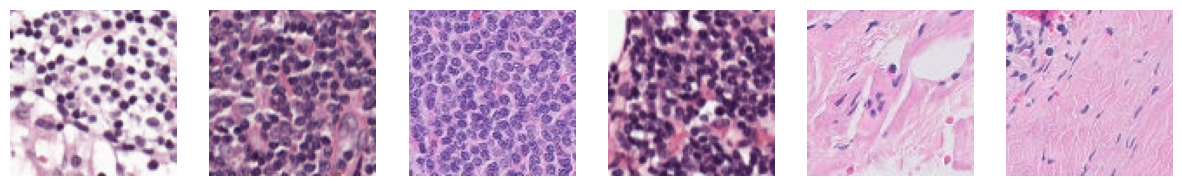

In [19]:
fig, axis = plt.subplots(nrows=1,ncols=6,figsize=(15,4))
for i in range(6):
    axis[i].imshow(np.transpose(x_ref[i],(1,2,0)))
    axis[i].axis('off')

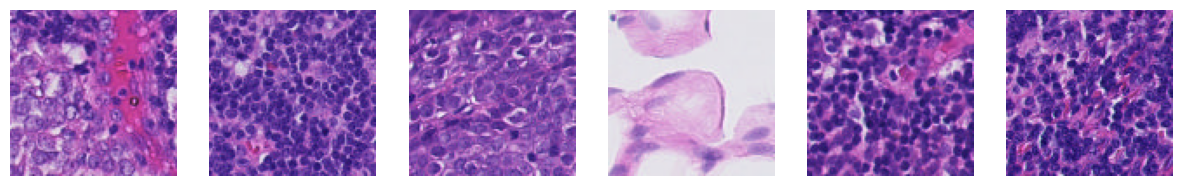

In [20]:
fig, axis = plt.subplots(nrows=1,ncols=6,figsize=(15,4))
for i in range(6):
    axis[i].imshow(np.transpose(x_test[i],(1,2,0)))
    axis[i].axis('off')